In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set seed
seed = 8888
rng = np.random.default_rng(seed)

# 1. State a clear question
- What is the causal effect of height on weight?

### Load data
The dataframe consists of the heights, weights, sex and age of individuals in a certain population.

In [3]:
df = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/pymc/pymc-resources/Rethinking_2/Data/Howell1.csv', sep=';')
df = df[df['age'] >= 18]
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


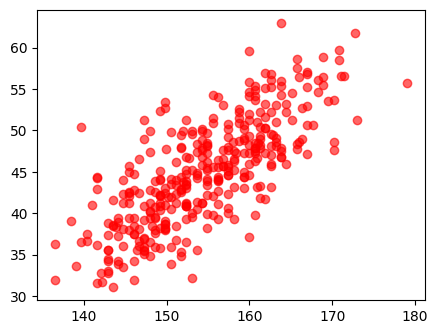

In [4]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(df['height'], df['weight'], c='#ff0000', alpha=0.6)
ax.set_aspect('equal')

plt.show()

# 2. Sketch out the causal assumptions (DAG) of the model
In this case, I have sketched out the DAG on my notebook.

# 3. Define a generative model
### Generate data
Here, we generate synthetic data based on causal assumptions of our system and visualise these data.

In [5]:
def sim_HW(H, a=0, b=0.5, sd=5):
    U = rng.normal(0, sd, size=len(H))
    W = a + b * H + U
    
    sim_data = pd.DataFrame({'height': H, 'weight': W})
    
    return sim_data

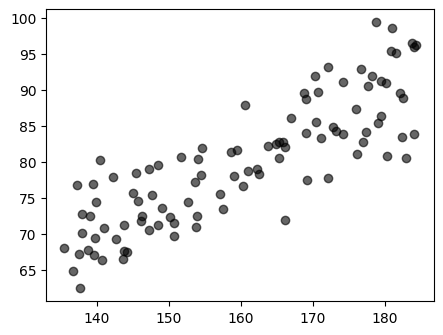

In [6]:
H = rng.uniform(135, 185, size=100)
sim_data = sim_HW(H, 0, 0.5, 5)

fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c='#000000', alpha=0.6)
ax.set_aspect('equal')

plt.show()

### Prior predictive distribution
Before we start running our statistical model, we do a prior predictive check. This is to make sure that our priors aren't totally crazy.

In [7]:
a = rng.normal(0, 10, size=100)
b = xr.DataArray(rng.uniform(0, 1, size=100), dims='b')

x = xr.DataArray(np.linspace(135,185), dims='x')
y = a.reshape(100,1) + b*x

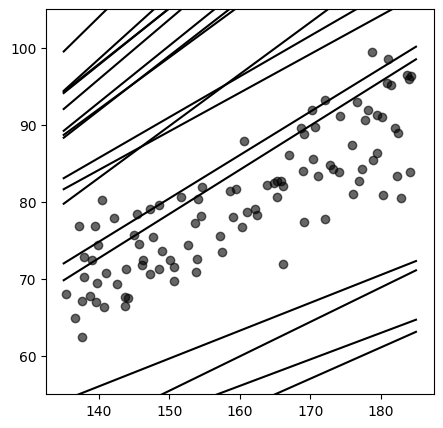

In [8]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c='#000000', alpha=0.6)
for i in range(50):
    ax.plot(x, y[i], color='black')

ax.set_ylim(55,105)

plt.show()

# 4. Design a statistical way to build the estimator using the generative model
### Fit model to generated data
Here, we fit a linear regression to the generated data.

In [9]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Uniform('beta', lower=0, upper=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Define likelihood
    weight_obs = pm.Normal('weight_obs', mu=alpha + beta*sim_data['height'], sigma=sigma, observed=sim_data['weight'])
    
    ## Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.887,4.427,-6.073,10.707,0.117,0.095,1431.0,1327.0,1.01
beta,0.481,0.028,0.431,0.536,0.001,0.001,1430.0,1332.0,1.00
sigma,4.674,0.341,4.017,5.289,0.008,0.006,1857.0,1725.0,1.00


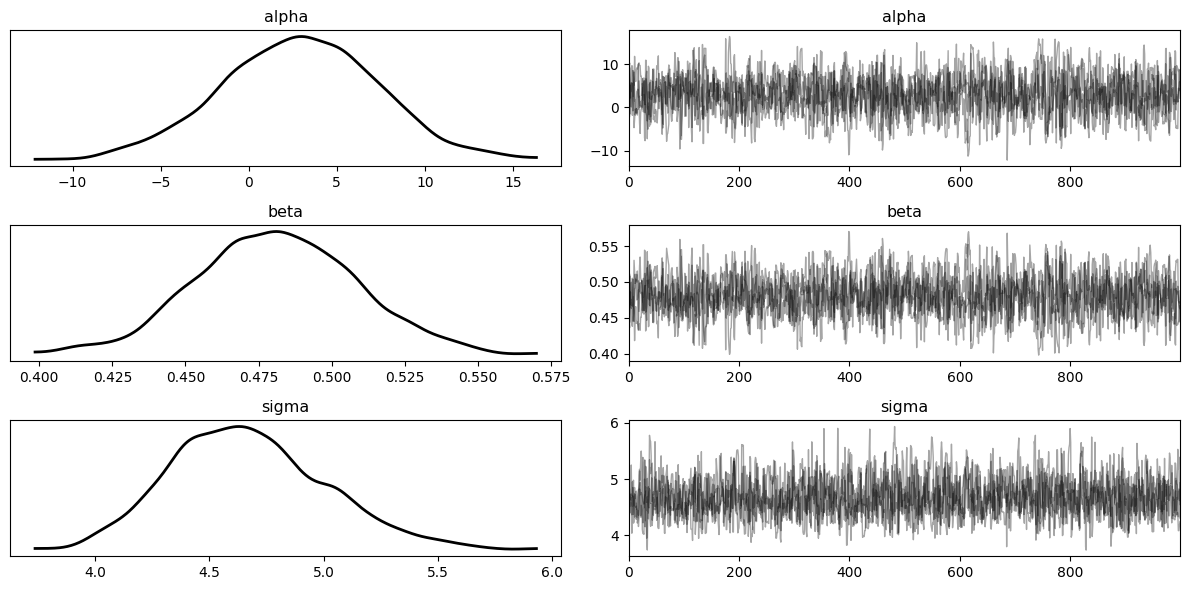

In [10]:
az.plot_trace(idata, combined=True, chain_prop={'color': ['black'], 'linewidth': [1,1,1,1,2]})
plt.tight_layout()
plt.show()

Now that we have the posterior distributions of our parameters, we can use them to simulate model fits to our generated data.

In [11]:
idata.posterior['weight_mod'] = idata.posterior['alpha'] + idata.posterior['beta'] * x

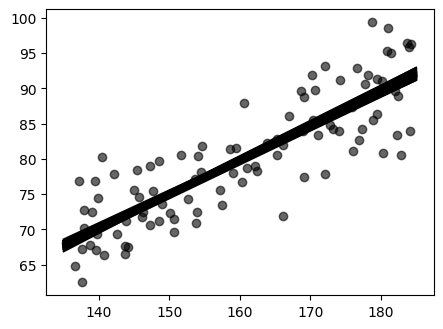

In [12]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(sim_data['height'], sim_data['weight'], c='#000000', alpha=0.6)
for i in range(50):
    ax.plot(x, idata.posterior['weight_mod'].mean(axis=0)[i], color='black')
ax.set_aspect('equal')

plt.show()

# 5. Analyse real data
Now that we know our model works with the synthetic data, we'll feed the real data from above.

In [13]:
df_sampled = df.sample(n=len(df))

In [14]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Uniform('beta', lower=0, upper=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Define likelihood
    weight_obs = pm.Normal('weight_obs', mu=alpha + beta*df_sampled['height'], sigma=sigma, observed=df_sampled['weight'])
    
    ## Inference
    idata = pm.sample(1000)
    
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-43.310,4.097,-51.064,-35.517,0.113,0.080,1325.0,1310.0,1.0
beta,0.571,0.026,0.521,0.622,0.001,0.001,1322.0,1328.0,1.0
sigma,4.279,0.160,3.995,4.576,0.004,0.003,1579.0,1772.0,1.0


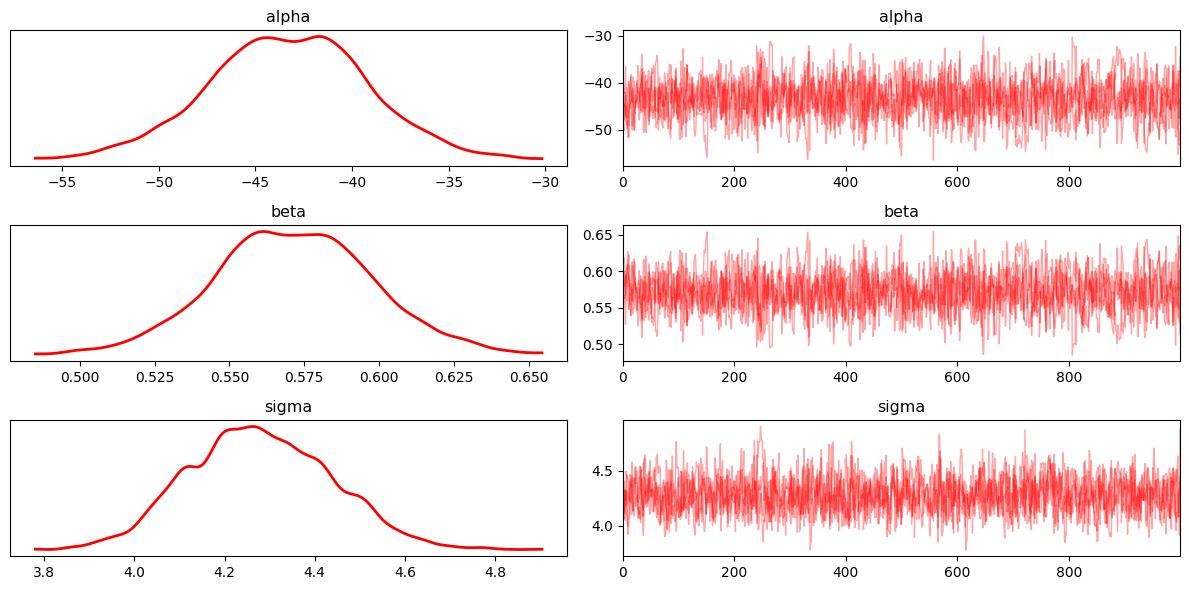

In [15]:
az.plot_trace(idata, combined=True, chain_prop={'color': ['red'], 'linewidth': [1,1,1,1,2]})
plt.tight_layout()
plt.show()

In [16]:
idata.posterior['weight_mod'] = idata.posterior['alpha'] + idata.posterior['beta'] * x

idata.posterior['weight_upper'] = idata.posterior['weight_mod'] + 2*idata.posterior['sigma']
idata.posterior['weight_lower'] = idata.posterior['weight_mod'] - 2*idata.posterior['sigma']

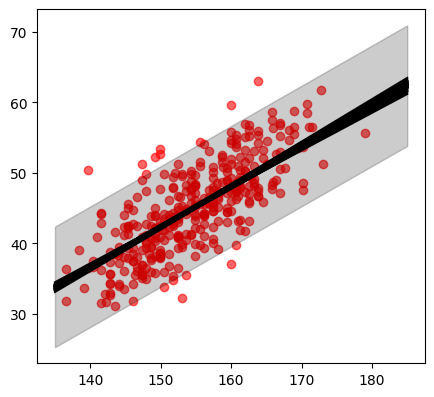

In [17]:
fig,ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(df['height'], df['weight'], c='#ff0000', alpha=0.6)
for i in range(50):
    ax.plot(x, idata.posterior['weight_mod'].mean(axis=0)[i], color='#000000')

ax.fill_between(x, idata.posterior['weight_lower'].mean(axis=(0,1)), idata.posterior['weight_upper'].mean(axis=(0,1)), color='#000000', alpha=0.2)
ax.set_aspect('equal')

plt.show()